In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("../data/finaldataset.csv")

In [3]:
# Data Preparation
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

#reformat year column
df['year'] = pd.to_datetime(df['year'], format='%Y') + pd.offsets.YearEnd(0)

#Obtaining bilateral trade value: 
#Use Singapore-reported export value by default, if NaN, use trade partner reported import value 
#combined trade series ensure broader coverage
#method adapted from CEPII Trade and Production database (TradeProd)
#https://www.cepii.fr/DATA_DOWNLOAD/tradeprod/V202401/CEPII_TradeProd_V202401.pdf

df["all_exports_new"] = np.where(
    df["tradeflow_comtrade_o"].notna(), 
    df["tradeflow_comtrade_o"], 
    np.where(
        df["tradeflow_comtrade_d"].notna(), 
        df["tradeflow_comtrade_d"],
        np.nan
    )
)

# log transformation of variables
df["log_all_exports_new"] = np.log1p(df["all_exports_new"])
df["log_gdpcap_d"] = np.log1p(df["gdpcap_d"])
df["log_pop_d"] = np.log1p(df["pop_d"])
df["log_distcap"] = np.log1p(df["distcap"])

# Inspect all countries in the dataset and remove those with very few observations
df = df[df["country_d"] != "Taiwan"]
df = df[df["country_d"] != "North Korea"]
df = df[df["country_d"] != "Liechtenstein"]
df = df[df["country_d"] != "Monaco"]
df = df[df["country_d"] != "Yugoslavia"]
df = df[df["country_d"] != "Sao Tome and Principe"]
df = df[df["country_d"] != "Iraq"]
df = df[df["country_d"] != "Botswana"]
df = df[df["country_d"] != "Lesotho"]
df = df[df["country_d"] != "Luxembourg"]
df = df[df["country_d"] != "Sudan"]
df = df[df["country_d"] != "Equatorial Guinea"]

In [4]:
#import libraries
import darts
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.dataprocessing.transformers import MissingValuesFiller
from darts.utils.statistics import plot_acf, plot_pacf
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
from darts.models import TCNModel
from darts.models import NBEATSModel
from darts.models import RandomForest
from darts.utils.likelihood_models import GaussianLikelihood
from darts.metrics import mape, mae, rmse, r2_score
from darts.timeseries import concatenate
import torch

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# preliminary trial (train on 1989-2019, test on 2020)

# Define year range
full_years = pd.date_range(start="1989-12-31", end="2020-12-31", freq="YE")
full_years_df = pd.DataFrame({"year": full_years})

# Reformat into Darts TimeSeries objects & Split into train/test sets

# Train-test split based on forecast horizon
forecast_horizon = 1  # Forecast 1 year ahead

# Get the last valid time (latest available year)
last_valid_time = df.set_index("year")['distcap'].last_valid_index()
 
# Compute the train-test split point: leave the last year for testing
split_point = last_valid_time - pd.DateOffset(years=forecast_horizon)

print(f"Split point: {split_point.year}") 

target_series_dict = {}  #
past_covariates_dict = {}  # 


# Initialize lists for train/test sets
train_series_list = []
test_series_list = []
past_covariates_list = []
country_list = []


for country in df['country_d'].unique():

    country_list.append(country)
    
    # Filter for the current country
    df_country = df[df['country_d'] == country].copy()

    # Merge with full years to ensure all dates are present
    df_country = pd.merge(full_years_df, df_country, on="year", how="left")

    # Drop duplicates of rows (if applicable)
    df_country = df_country.drop_duplicates(subset=["year"], keep="first")

    vars_to_fill = ['log_all_exports_new', 'geodistance', 'log_distcap', 'log_gdpcap_d', 'log_pop_d']
    
    before_2009 = df_country["year"] <= pd.Timestamp("2008-12-31")
    df_before_2009 = df_country[before_2009].copy()
    
    # Interpolate pre-2009
    for var in vars_to_fill:

        df_country.loc[before_2009, var] = (
            df_country.loc[before_2009, var]
            .interpolate(method="linear", limit_direction="both")
        )
    
    # Handle 2009 special case
    mask_2009 = df_country["year"] == pd.Timestamp("2009-12-31")
    for var in vars_to_fill:
        if df_country.loc[mask_2009, var].isna().any():
            last_val = df_before_2009[var].dropna().iloc[-1]
            df_country.loc[mask_2009, var] = last_val

    
    # Step 3: Forward-fill for 2009 onwards
    from_2009 = df_country["year"] >= pd.Timestamp("2009-12-31")
    df_country.loc[from_2009, vars_to_fill] = (
        df_country.loc[from_2009, vars_to_fill].ffill()
    )
    
    # Step 4: Rebuild TimeSeries
    target_series = TimeSeries.from_dataframe(df_country, "year", ["log_all_exports_new"])
    past_covariates = TimeSeries.from_dataframe(df_country, "year", ['geodistance', 'log_distcap', 'log_gdpcap_d', 'log_pop_d'])
    
    train_series, test_series = target_series.split_after(split_point)

    # Convert to float32 for Darts compatibility
    train_series_list.append(train_series.astype(np.float32))
    test_series_list.append(test_series.astype(np.float32))
    past_covariates_list.append(past_covariates.astype(np.float32))

Split point: 2019


<Axes: xlabel='year'>

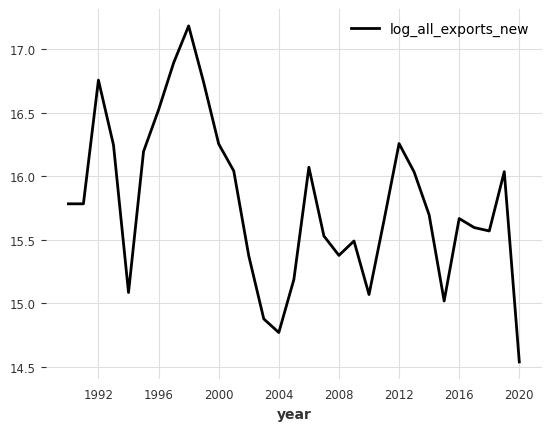

In [6]:
train_series_list[160].plot()

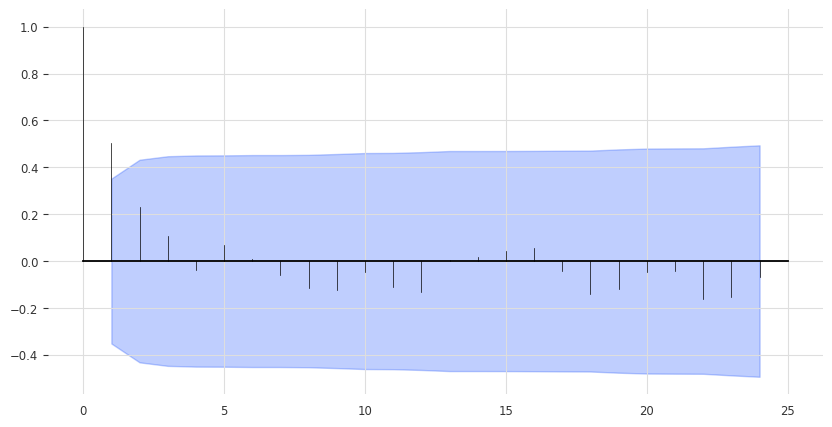

In [7]:
#View ACF by country
series = train_series_list[160]
plot_acf(series)

In [8]:
#Expanding Window CV (Random Forest - Best performing model)

import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import RandomForest
from darts.dataprocessing.transformers import MissingValuesFiller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from itertools import product
import warnings
warnings.filterwarnings('ignore')  

# ====== Custom Metrics ======
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_aic_bic(y_true, y_pred, n_params):
    residuals = np.array(y_true) - np.array(y_pred)
    n = len(residuals)
    rss = np.sum(residuals**2)
    if rss < 1e-10: rss = 1e-10
    aic = n * np.log(rss/n) + 2 * n_params
    bic = n * np.log(rss/n) + n_params * np.log(n)
    return aic, bic

# ====== Hyperparameter Grid ======
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, None], 
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

param_combinations = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

# ====== Main Config ======
forecast_horizon = 1
min_train_years = 20
n_estimated_params = 15  # Updated for AIC/BIC calc

metrics_dict = {
    "country": [], "mape": [], "mae": [], "mse": [], 
    "rmse": [], "aic": [], "bic": [], "best_params": [], "used_lag": []
}


# List of optimal lags
optimal_lags_list = [2, 2, 3, 2, 3, 1, 2, 3, 1, 3, 1, 3, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 
                     1, 1, 2, 1, 2, 2, 1, 3, 2, 3, 1, 1, 1, 1, 2, 3, 1, 2, 1, 1, 2, 2, 3, 
                     2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 3, 2, 3, 
                     3, 3, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 1, 2, 1, 
                     2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 1, 2, 2, 3, 1, 3, 3, 
                     3, 3, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 
                     2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 3, 2, 1, 2, 1, 1] 
country_list = df['country_d'].unique()
optimal_lags_dict = dict(zip(country_list, optimal_lags_list))

# ====== Main Loop ======
for country in tqdm(df['country_d'].unique(), desc="Random Forest Tuning"):
    df_country = df[df['country_d'] == country].copy()
    df_country = pd.merge(full_years_df, df_country, on="year", how="left").drop_duplicates("year")

    
    vars_to_fill = ['log_all_exports_new', 'geodistance', 'log_distcap', 'log_gdpcap_d', 'log_pop_d']
    
    before_2009 = df_country["year"] <= pd.Timestamp("2008-12-31")
    df_before_2009 = df_country[before_2009].copy()
    
    # Interpolate pre-2009
    for var in vars_to_fill:
        df_country.loc[before_2009, var] = (
            df_country.loc[before_2009, var]
            .interpolate(method="linear", limit_direction="both")
        )
    
    # Handle 2009 special case
    mask_2009 = df_country["year"] == pd.Timestamp("2009-12-31")
    for var in vars_to_fill:
        if df_country.loc[mask_2009, var].isna().any():
            last_val = df_before_2009[var].dropna().iloc[-1]
            df_country.loc[mask_2009, var] = last_val

    
    # Forward-fill for 2009 onwards
    from_2009 = df_country["year"] >= pd.Timestamp("2009-12-31")
    df_country.loc[from_2009, vars_to_fill] = (
        df_country.loc[from_2009, vars_to_fill].ffill()
    )
    
    # Rebuild TimeSeries
    target_series = TimeSeries.from_dataframe(df_country, "year", ["log_all_exports_new"])
    past_cov = TimeSeries.from_dataframe(df_country, "year", ['geodistance', 'log_distcap', 'log_gdpcap_d', 'log_pop_d'])
    
    if len(target_series) < min_train_years + forecast_horizon:
        continue

    lag = optimal_lags_dict.get(country, 1)  

    best_score = float('inf')
    best_params = None

    for params in param_combinations: 
        try:
            model = RandomForest(
                lags=[-i for i in range(1, lag+1)],
                lags_past_covariates=[-1],
                output_chunk_length=forecast_horizon,
                random_state=42,
                **params
            )
            model.fit(series=target_series[:min_train_years], past_covariates=past_cov[:min_train_years])
            pred = model.predict(
                n=forecast_horizon,
                series=target_series[:min_train_years],
                past_covariates=past_cov[:min_train_years+1]
            )
            current_score = mean_absolute_error(
                target_series.values()[min_train_years:min_train_years+forecast_horizon],
                pred.values()
            )
            if current_score < best_score:
                best_score = current_score
                best_params = params
        except:
            continue

    if best_params is None:
        continue

    # Final model
    final_model = RandomForest(
        lags=[-i for i in range(1, lag+1)],
        lags_past_covariates=[-1],
        output_chunk_length=forecast_horizon,
        random_state=42,
        **best_params
    )

    y_true, y_pred = [], []
    for i in range(min_train_years, len(target_series) - forecast_horizon):
        train_s = target_series[:i+1]
        train_c = past_cov[:i+1]
        final_model.fit(train_s, past_covariates=train_c)
        pred = final_model.predict(
            n=forecast_horizon,
            series=train_s,
            past_covariates=past_cov[:i+forecast_horizon+1]
        )
        y_true.append(target_series.values()[i+1][0])
        y_pred.append(pred.values()[0][0])

    
    if len(y_true) >= 3:
        aic, bic = calculate_aic_bic(y_true, y_pred, n_estimated_params)
        metrics_dict["country"].append(country)
        metrics_dict["mape"].append(mean_absolute_percentage_error(y_true, y_pred))
        metrics_dict["mae"].append(mean_absolute_error(y_true, y_pred))
        metrics_dict["mse"].append(mean_squared_error(y_true, y_pred))
        metrics_dict["rmse"].append(np.sqrt(mean_squared_error(y_true, y_pred)))
        metrics_dict["aic"].append(aic)
        metrics_dict["bic"].append(bic)
        metrics_dict["best_params"].append(str(best_params))
        metrics_dict["used_lag"].append(lag)

# ====== Final Reporting ======
results_df = pd.DataFrame(metrics_dict)
aggregate_metrics = pd.DataFrame({
    "Metric": ["MAPE (%)", "MAE", "MSE", "RMSE", "AIC", "BIC"],
    "Mean": results_df[["mape", "mae", "mse", "rmse", "aic", "bic"]].mean().values,
    "Median": results_df[["mape", "mae", "mse", "rmse", "aic", "bic"]].median().values
})

print("\n=== Country-wise Results ===")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(results_df.round(4))

print("\n=== Aggregate Metrics ===")
display(aggregate_metrics.round(4))


Random Forest Tuning: 100%|███████████████████| 161/161 [09:00<00:00,  3.35s/it]


=== Country-wise Results ===


,country,mape,mae,mse,rmse,aic,bic,best_params,used_lag
0,Afghanistan,2.2842,0.3872,0.2850,0.5339,16.1939,22.1624,"{'n_estimators': 50, 'max_depth': 5, 'min_samp...",2
1,Angola,2.7773,0.5224,0.4308,0.6563,20.7366,26.7051,"{'n_estimators': 50, 'max_depth': 10, 'min_sam...",2
2,Albania,4.0541,0.5531,0.5251,0.7246,22.9138,28.8823,"{'n_estimators': 100, 'max_depth': 5, 'min_sam...",3
3,Andorra,8.0648,1.0688,1.7860,1.3364,36.3795,42.3480,"{'n_estimators': 50, 'max_depth': 10, 'min_sam...",2
4,United Arab Emirates,0.9502,0.2104,0.0556,0.2357,-1.7947,4.1737,"{'n_estimators': 50, 'max_depth': 5, 'min_samp...",3
5,Argentina,1.7484,0.3320,0.1576,0.3970,9.6740,15.6424,"{'n_estimators': 50, 'max_depth': 10, 'min_sam...",1
6,Armenia,3.4779,0.4812,0.3222,0.5677,17.5430,23.5114,"{'n_estimators': 150, 'max_depth': 10, 'min_sa...",2
7,Australia,0.9680,0.2253,0.0681,0.2610,0.4488,6.4172,"{'n_estimators': 100, 'max_depth': 5, 'min_sam...",3
8,Austria,1.0846,0.2070,0.0878,0.2963,3.2398,9.2082,"{'n_estimators': 50, 'max_depth': 5, 'min_samp...",1
9,Azerbaijan,4.4029,0.8023,1.0595,1.0293,30.6360,36.6044,"{'n_estimators': 100, 'max_depth': 5, 'min_sam...",3



=== Aggregate Metrics ===


,Metric,Mean,Median
0,MAPE (%),2.9051,2.2842
1,MAE,0.4736,0.3872
2,MSE,0.5398,0.2414
3,RMSE,0.5984,0.4914
4,AIC,13.7849,14.3672
5,BIC,19.7533,20.3356


In [9]:
# Predict 2021 log_all_trade_new using Random Forest (Best performing model)

rf_predictions_2021 = []

for country in tqdm(df['country_d'].unique(), desc="Predicting 2021"):
    if country not in results_df['country'].values:
        continue

    df_country = df[df['country_d'] == country].copy()
    df_country = pd.merge(full_years_df, df_country, on="year", how="left").drop_duplicates("year")

    vars_to_fill = ['log_all_exports_new', 'geodistance', 'log_distcap', 'log_gdpcap_d', 'log_pop_d']
    
    before_2009 = df_country["year"] <= pd.Timestamp("2008-12-31")
    df_before_2009 = df_country[before_2009].copy()
    
    # Interpolate pre-2009
    for var in vars_to_fill:
        df_country.loc[before_2009, var] = (
            df_country.loc[before_2009, var]
            .interpolate(method="linear", limit_direction="both")
        )
    
    # Step 2: Handle 2009 special case
    mask_2009 = df_country["year"] == pd.Timestamp("2009-12-31")
    for var in vars_to_fill:
        if df_country.loc[mask_2009, var].isna().any():
            last_val = df_before_2009[var].dropna().iloc[-1]
            df_country.loc[mask_2009, var] = last_val

    
    # Step 3: Forward-fill for 2009 onwards
    from_2009 = df_country["year"] >= pd.Timestamp("2009-12-31")
    df_country.loc[from_2009, vars_to_fill] = (
        df_country.loc[from_2009, vars_to_fill].ffill()
    )
    
    # Step 4: Rebuild TimeSeries
    target_series = TimeSeries.from_dataframe(df_country, "year", ["log_all_exports_new"])
    past_cov = TimeSeries.from_dataframe(df_country, "year", ['geodistance', 'log_distcap', 'log_gdpcap_d', 'log_pop_d'])

    # Get best parameters from earlier
    idx = results_df[results_df['country'] == country].index[0]
    best_params_str = results_df.loc[idx, 'best_params']
    best_params = eval(best_params_str)  # Convert back to dict
    lag = results_df.loc[idx, 'used_lag']

    final_model = RandomForest(
        lags=[-i for i in range(1, lag + 1)],
        lags_past_covariates=[-1],
        output_chunk_length=1,
        random_state=42,
        **best_params   # use best parameters from previous cell
    )

    try:
        final_model.fit(target_series, past_covariates=past_cov)
        forecast = final_model.predict(
            n=1,
            series=target_series,
            past_covariates=past_cov
        )
        pred_value = forecast.values()[0][0]
        rf_predictions_2021.append({
            "country": country,
            "log_all_trade_new_2021": pred_value
        })
    except:
        continue

# ====== Output Prediction DataFrame ======
pred_df_2021 = pd.DataFrame(rf_predictions_2021)

# Add exp_export_2021 by un-logging the prediction
pred_df_2021["exp_export_2021"] = np.exp(pred_df_2021["log_all_trade_new_2021"])

# Add country_id_d by merging from the original dataset
country_ids = df[["country_d", "country_id_d"]].drop_duplicates()
pred_df_2021 = pd.merge(pred_df_2021, country_ids, left_on="country", right_on="country_d", how="left")
pred_df_2021.drop(columns=["country_d"], inplace=True)

# Get geodistance for each country
geodistance = df[df["year"] == pd.Timestamp("2020-12-31")][["country_d", "geodistance"]].drop_duplicates()
pred_df_2021 = pd.merge(pred_df_2021, geodistance, left_on="country", right_on="country_d", how="left")
pred_df_2021.drop(columns=["country_d"], inplace=True)

pred_df_2021 = pred_df_2021[["country", "country_id_d", "geodistance", "log_all_trade_new_2021", "exp_export_2021"]]

# Display
print("\n=== Predicted trade value for 2021 ===")
display(pred_df_2021)

#download dataset for frontend usage
#pred_df_2021.to_csv("recommendations.csv", index=False)

Predicting 2021: 100%|████████████████████████| 161/161 [00:06<00:00, 23.42it/s]


=== Predicted trade value for 2021 ===


,country,country_id_d,geodistance,log_all_trade_new_2021,exp_export_2021
0,Afghanistan,AFG,68.490199,16.831087,2.040086e+07
1,Angola,AGO,70.217862,18.584943,1.178523e+08
2,Albania,ALB,76.406873,14.155339,1.404706e+06
3,Andorra,AND,77.127245,13.303925,5.995440e+05
4,United Arab Emirates,ARE,51.774788,21.928032,3.335978e+09
...,...,...,...,...,...
156,Samoa,WSM,45.656378,17.468057,3.857278e+07
157,Yemen,YEM.2,71.356938,16.535099,1.517408e+07
158,South Africa,ZAF,43.813577,20.020070,4.950006e+08
159,Zambia,ZMB,42.131346,15.112759,3.659213e+06


In [10]:
#Expanding Window CV (XGBoost)

import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import XGBModel
from darts.dataprocessing.transformers import MissingValuesFiller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from itertools import product
import warnings
warnings.filterwarnings('ignore')  

# ====== Custom Metrics ======
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_aic_bic(y_true, y_pred, n_params):
    residuals = np.array(y_true) - np.array(y_pred)
    n = len(residuals)
    rss = np.sum(residuals**2)
    if rss < 1e-10: rss = 1e-10
    aic = n * np.log(rss/n) + 2 * n_params
    bic = n * np.log(rss/n) + n_params * np.log(n)
    return aic, bic

# ====== Hyperparameter Grid ======
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, None],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

param_combinations = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]


# ====== Main Config ======
forecast_horizon = 1
min_train_years = 20
n_estimated_params = 15  # Updated for AIC/BIC calc

metrics_dict = {
    "country": [], "mape": [], "mae": [], "mse": [], 
    "rmse": [], "aic": [], "bic": [], "best_params": [], "used_lag": []
}


# List of optimal lags
optimal_lags_list = [2, 2, 3, 2, 3, 1, 2, 3, 1, 3, 1, 3, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 
                     1, 1, 2, 1, 2, 2, 1, 3, 2, 3, 1, 1, 1, 1, 2, 3, 1, 2, 1, 1, 2, 2, 3, 
                     2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 3, 2, 3, 
                     3, 3, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 1, 2, 1, 
                     2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 1, 2, 2, 3, 1, 3, 3, 
                     3, 3, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 
                     2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 3, 2, 1, 2, 1, 1] 
country_list = df['country_d'].unique()
optimal_lags_dict = dict(zip(country_list, optimal_lags_list))

# ====== Main Loop ======
for country in tqdm(df['country_d'].unique(), desc="XGBoost Tuning"):
    df_country = df[df['country_d'] == country].copy()
    df_country = pd.merge(full_years_df, df_country, on="year", how="left").drop_duplicates("year")


    # List of variables to process
    vars_to_fill = ['log_all_exports_new', 'geodistance', 'log_distcap', 'log_gdpcap_d', 'log_pop_d']
    
    before_2009 = df_country["year"] <= pd.Timestamp("2008-12-31")
    df_before_2009 = df_country[before_2009].copy()

    # Interpolate pre-2009
    for var in vars_to_fill:
        df_country.loc[before_2009, var] = (
            df_country.loc[before_2009, var]
            .interpolate(method="linear", limit_direction="both")
        )
    
    # Handle 2009 special case
    mask_2009 = df_country["year"] == pd.Timestamp("2009-12-31")
    for var in vars_to_fill:
        if df_country.loc[mask_2009, var].isna().any():
            last_val = df_before_2009[var].dropna().iloc[-1]
            df_country.loc[mask_2009, var] = last_val

    
    # Forward-fill for 2009 onwards
    from_2009 = df_country["year"] >= pd.Timestamp("2009-12-31")
    df_country.loc[from_2009, vars_to_fill] = (
        df_country.loc[from_2009, vars_to_fill].ffill()
    )
    
    # Rebuild TimeSeries
    target_series = TimeSeries.from_dataframe(df_country, "year", ["log_all_exports_new"])
    past_cov = TimeSeries.from_dataframe(df_country, "year", ['geodistance', 'log_distcap', 'log_gdpcap_d', 'log_pop_d'])
    
    if len(target_series) < min_train_years + forecast_horizon:
        continue

    lag = optimal_lags_dict.get(country, 1)  

    # Grid Search
    best_score = float('inf')
    best_params = None

    for params in param_combinations: 
        try:
            model = XGBModel(
                lags=[-i for i in range(1, lag+1)],
                lags_past_covariates=[-1],
                output_chunk_length=forecast_horizon,
                random_state=42,
                **params
            )
            model.fit(series=target_series[:min_train_years], past_covariates=past_cov[:min_train_years])
            pred = model.predict(
                n=forecast_horizon,
                series=target_series[:min_train_years],
                past_covariates=past_cov[:min_train_years+1]
            )
            current_score = mean_absolute_error(
                target_series.values()[min_train_years:min_train_years+forecast_horizon],
                pred.values()
            )
            if current_score < best_score:
                best_score = current_score
                best_params = params
        except:
            continue

    if best_params is None:
        continue
    
    # Final model 
    final_model = XGBModel(
        lags=[-i for i in range(1, lag+1)],
        lags_past_covariates=[-1],
        output_chunk_length=forecast_horizon,
        random_state=42,
        **best_params
    )

    y_true, y_pred = [], []
    for i in range(min_train_years, len(target_series) - forecast_horizon):
        train_s = target_series[:i+1]
        train_c = past_cov[:i+1]
        final_model.fit(train_s, past_covariates=train_c)
        pred = final_model.predict(
            n=forecast_horizon,
            series=train_s,
            past_covariates=past_cov[:i+forecast_horizon+1]
        )
        y_true.append(target_series.values()[i+1][0])
        y_pred.append(pred.values()[0][0])

    if len(y_true) >= 3:
        aic, bic = calculate_aic_bic(y_true, y_pred, n_estimated_params)
        metrics_dict["country"].append(country)
        metrics_dict["mape"].append(mean_absolute_percentage_error(y_true, y_pred))
        metrics_dict["mae"].append(mean_absolute_error(y_true, y_pred))
        metrics_dict["mse"].append(mean_squared_error(y_true, y_pred))
        metrics_dict["rmse"].append(np.sqrt(mean_squared_error(y_true, y_pred)))
        metrics_dict["aic"].append(aic)
        metrics_dict["bic"].append(bic)
        metrics_dict["best_params"].append(str(best_params))
        metrics_dict["used_lag"].append(lag)

# ====== Final Reporting ======
results_df = pd.DataFrame(metrics_dict)
aggregate_metrics = pd.DataFrame({
    "Metric": ["MAPE (%)", "MAE", "MSE", "RMSE", "AIC", "BIC"],
    "Mean": results_df[["mape", "mae", "mse", "rmse", "aic", "bic"]].mean().values,
    "Median": results_df[["mape", "mae", "mse", "rmse", "aic", "bic"]].median().values
})

print("\n=== Country-wise Results ===")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(results_df.round(4))

print("\n=== Aggregate Metrics ===")
display(aggregate_metrics.round(4))


XGBoost Tuning: 100%|█████████████████████████| 161/161 [02:51<00:00,  1.07s/it]


=== Country-wise Results ===


,country,mape,mae,mse,rmse,aic,bic,best_params,used_lag
0,Afghanistan,2.6136,0.4411,0.3317,0.5760,17.8627,23.8311,"{'n_estimators': 100, 'max_depth': 5, 'learnin...",2
1,Angola,2.8653,0.5403,0.5714,0.7559,23.8439,29.8123,"{'n_estimators': 150, 'max_depth': 10, 'learni...",2
2,Albania,5.2739,0.7247,0.7824,0.8845,27.3003,33.2687,"{'n_estimators': 150, 'max_depth': 10, 'learni...",3
3,Andorra,10.7004,1.4414,2.6499,1.6278,40.7196,46.6881,"{'n_estimators': 100, 'max_depth': 10, 'learni...",2
4,United Arab Emirates,0.8516,0.1886,0.0505,0.2247,-2.8494,3.1190,"{'n_estimators': 100, 'max_depth': 5, 'learnin...",3
5,Argentina,1.4226,0.2697,0.1057,0.3251,5.2821,11.2505,"{'n_estimators': 50, 'max_depth': 10, 'learnin...",1
6,Armenia,2.3751,0.3325,0.1954,0.4420,12.0398,18.0082,"{'n_estimators': 150, 'max_depth': 5, 'learnin...",2
7,Australia,1.0735,0.2507,0.0864,0.2939,3.0603,9.0287,"{'n_estimators': 50, 'max_depth': 5, 'learning...",3
8,Austria,1.2801,0.2435,0.0887,0.2978,3.3522,9.3206,"{'n_estimators': 100, 'max_depth': 5, 'learnin...",1
9,Azerbaijan,7.3081,1.3298,2.7599,1.6613,41.1673,47.1357,"{'n_estimators': 50, 'max_depth': 5, 'learning...",3



=== Aggregate Metrics ===


,Metric,Mean,Median
0,MAPE (%),3.0657,2.2501
1,MAE,0.4993,0.3865
2,MSE,0.6284,0.2471
3,RMSE,0.6302,0.4971
4,AIC,14.7270,14.6244
5,BIC,20.6954,20.5928


In [11]:
#Expanding Window CV (LightGBM)

import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import LightGBMModel
from darts.dataprocessing.transformers import MissingValuesFiller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# ====== Custom Metrics ======
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_aic_bic(y_true, y_pred, n_params):
    residuals = np.array(y_true) - np.array(y_pred)
    n = len(residuals)
    rss = np.sum(residuals**2)
    if rss < 1e-10: rss = 1e-10
    aic = n * np.log(rss/n) + 2 * n_params
    bic = n * np.log(rss/n) + n_params * np.log(n)
    return aic, bic

# ====== Hyperparameter Grid ======
param_grid = {
    'n_estimators': [10, 25, 50],              
    'max_depth': [2, 3, 4],                   
    'learning_rate': [0.05, 0.1, 0.2],
    'min_data_in_leaf': [1, 2, 5],             
    'min_data_in_bin': [1, 3, 5],              
    'feature_fraction': [1.0],                
    'bagging_fraction': [1.0],                
    'lambda_l1': [0.0],                      
    'lambda_l2': [0.0],
    'verbosity': [-1]                          
}


param_combinations = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

# ====== Main Config ======
forecast_horizon = 1
min_train_years = 20
n_estimated_params = 15

metrics_dict = {
    "country": [], "mape": [], "mae": [], "mse": [], 
    "rmse": [], "aic": [], "bic": [], "best_params": [], "used_lag": []
}


# List of optimal lags
optimal_lags_list = [2, 2, 3, 2, 3, 1, 2, 3, 1, 3, 1, 3, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 
                     1, 1, 2, 1, 2, 2, 1, 3, 2, 3, 1, 1, 1, 1, 2, 3, 1, 2, 1, 1, 2, 2, 3, 
                     2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 3, 2, 3, 
                     3, 3, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 1, 2, 1, 
                     2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 1, 2, 2, 3, 1, 3, 3, 
                     3, 3, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 
                     2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 3, 2, 1, 2, 1, 1] 
country_list = df['country_d'].unique()
optimal_lags_dict = dict(zip(country_list, optimal_lags_list))

# ====== Main Loop ======
for country in tqdm(df['country_d'].unique(), desc="LightGBM Tuning"):
    df_country = df[df['country_d'] == country].copy()
    df_country = pd.merge(full_years_df, df_country, on="year", how="left").drop_duplicates("year")

    vars_to_fill = ['log_all_exports_new', 'geodistance', 'log_distcap', 'log_gdpcap_d', 'log_pop_d']
    
    before_2009 = df_country["year"] <= pd.Timestamp("2008-12-31")
    df_before_2009 = df_country[before_2009].copy()
    
    
    # Interpolate pre-2009
    for var in vars_to_fill:
        df_country.loc[before_2009, var] = (
            df_country.loc[before_2009, var]
            .interpolate(method="linear", limit_direction="both")
        )
    
    # Handle 2009 special case
    mask_2009 = df_country["year"] == pd.Timestamp("2009-12-31")
    for var in vars_to_fill:
        if df_country.loc[mask_2009, var].isna().any():
            last_val = df_before_2009[var].dropna().iloc[-1]
            df_country.loc[mask_2009, var] = last_val

    
    # Forward-fill for 2009 onwards
    from_2009 = df_country["year"] >= pd.Timestamp("2009-12-31")
    df_country.loc[from_2009, vars_to_fill] = (
        df_country.loc[from_2009, vars_to_fill].ffill()
    )
    
    # Rebuild TimeSeries
    target_series = TimeSeries.from_dataframe(df_country, "year", ["log_all_exports_new"])
    past_cov = TimeSeries.from_dataframe(df_country, "year", ['geodistance', 'log_distcap', 'log_gdpcap_d', 'log_pop_d'])

    if len(target_series) < min_train_years + forecast_horizon:
        continue

    lag = optimal_lags_dict.get(country, 1)

    best_score = float('inf')
    best_params = None

    # Grid Search
    for params in param_combinations:
        try:
            model = LightGBMModel(
                lags=[-i for i in range(1, lag+1)],
                lags_past_covariates=[-1],
                output_chunk_length=forecast_horizon,
                random_state=42,
                **params
            )

            model.fit(series=target_series[:min_train_years], past_covariates=past_cov[:min_train_years])
            pred = model.predict(
                n=forecast_horizon,
                series=target_series[:min_train_years],
                past_covariates=past_cov[:min_train_years+1]
            )
            current_score = mean_absolute_error(
                target_series.values()[min_train_years:min_train_years+forecast_horizon],
                pred.values()
            )
            if current_score < best_score:
                best_score = current_score
                best_params = params
        except:
            continue

    if best_params is None:
        continue

    # Final Model
    final_model = LightGBMModel(
        lags=[-i for i in range(1, lag+1)],
        lags_past_covariates=[-1],
        output_chunk_length=forecast_horizon,
        random_state=42,
        **best_params
    )

    y_true, y_pred = [], []
    for i in range(min_train_years, len(target_series) - forecast_horizon):
        train_s = target_series[:i+1]
        train_c = past_cov[:i+1]
        final_model.fit(train_s, past_covariates=train_c)
        pred = final_model.predict(
            n=forecast_horizon,
            series=train_s,
            past_covariates=past_cov[:i+forecast_horizon+1]
        )
        y_true.append(target_series.values()[i+1][0])
        y_pred.append(pred.values()[0][0])

    if len(y_true) >= 3:
        aic, bic = calculate_aic_bic(y_true, y_pred, n_estimated_params)
        metrics_dict["country"].append(country)
        metrics_dict["mape"].append(mean_absolute_percentage_error(y_true, y_pred))
        metrics_dict["mae"].append(mean_absolute_error(y_true, y_pred))
        metrics_dict["mse"].append(mean_squared_error(y_true, y_pred))
        metrics_dict["rmse"].append(np.sqrt(mean_squared_error(y_true, y_pred)))
        metrics_dict["aic"].append(aic)
        metrics_dict["bic"].append(bic)
        metrics_dict["best_params"].append(str(best_params))
        metrics_dict["used_lag"].append(lag)

# ====== Final Reporting ======
results_df = pd.DataFrame(metrics_dict)
aggregate_metrics = pd.DataFrame({
    "Metric": ["MAPE (%)", "MAE", "MSE", "RMSE", "AIC", "BIC"],
    "Mean": results_df[["mape", "mae", "mse", "rmse", "aic", "bic"]].mean().values,
    "Median": results_df[["mape", "mae", "mse", "rmse", "aic", "bic"]].median().values
})

print("\n=== Country-wise Results ===")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(results_df.round(4))

print("\n=== Aggregate Metrics ===")
display(aggregate_metrics.round(4))


LightGBM Tuning: 100%|████████████████████████| 161/161 [07:10<00:00,  2.67s/it]


=== Country-wise Results ===


,country,mape,mae,mse,rmse,aic,bic,best_params,used_lag
0,Afghanistan,2.5171,0.4258,0.3103,0.5570,17.1269,23.0953,"{'n_estimators': 10, 'max_depth': 2, 'learning...",2
1,Angola,2.9135,0.5492,0.4523,0.6725,21.2730,27.2414,"{'n_estimators': 50, 'max_depth': 4, 'learning...",2
2,Albania,3.7223,0.5084,0.4890,0.6993,22.1317,28.1001,"{'n_estimators': 25, 'max_depth': 2, 'learning...",3
3,Andorra,12.9795,1.7071,4.0021,2.0005,45.2551,51.2235,"{'n_estimators': 25, 'max_depth': 4, 'learning...",2
4,United Arab Emirates,0.8470,0.1877,0.0449,0.2119,-4.1401,1.8283,"{'n_estimators': 25, 'max_depth': 2, 'learning...",3
5,Argentina,1.3055,0.2482,0.1033,0.3215,5.0337,11.0021,"{'n_estimators': 25, 'max_depth': 3, 'learning...",1
6,Armenia,3.1507,0.4369,0.2700,0.5196,15.5978,21.5662,"{'n_estimators': 25, 'max_depth': 2, 'learning...",2
7,Australia,1.1059,0.2584,0.0847,0.2911,2.8502,8.8186,"{'n_estimators': 10, 'max_depth': 2, 'learning...",3
8,Austria,1.6914,0.3227,0.1908,0.4368,11.7798,17.7483,"{'n_estimators': 50, 'max_depth': 4, 'learning...",1
9,Azerbaijan,7.4145,1.3542,2.7182,1.6487,40.9998,46.9682,"{'n_estimators': 10, 'max_depth': 2, 'learning...",3



=== Aggregate Metrics ===


,Metric,Mean,Median
0,MAPE (%),3.1693,2.4399
1,MAE,0.5170,0.4258
2,MSE,0.6759,0.2851
3,RMSE,0.6577,0.5340
4,AIC,15.5796,16.1972
5,BIC,21.5480,22.1657


In [12]:
#Time-series forecasting baseline - Naive Mean

import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import NaiveMean
from darts.dataprocessing.transformers import MissingValuesFiller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Parameters
forecast_horizon = 1
min_train_years = 20
n_params = 1  # NaiveMean uses the mean only

# Initialize results storage
metrics = []


for country in tqdm(df['country_d'].unique(), desc="Evaluating Naive Mean"):
    # Prepare country data
    df_country = df[df['country_d'] == country].copy()
    df_country = pd.merge(full_years_df, df_country, on="year", how="left").drop_duplicates("year")
    
    before_2009 = df_country["year"] <= pd.Timestamp("2008-12-31")
    from_2009 = df_country["year"] >= pd.Timestamp("2009-12-31")

    # Interpolate and fill pre-2009
    df_country.loc[before_2009, "log_all_exports_new"] = (
        df_country.loc[before_2009, "log_all_exports_new"]
        .interpolate(method="linear", limit_direction = "both")
    )

    # If 2009 is NaN, fill it with the last available value from before 2009
    mask_2009 = df_country["year"] == pd.Timestamp("2009-12-31")
    if df_country.loc[mask_2009, "log_all_exports_new"].isna().any():
        last_val_pre_2009 = df_country.loc[before_2009, "log_all_exports_new"].dropna().iloc[-1]
        df_country.loc[mask_2009, "log_all_exports_new"] = last_val_pre_2009

    # Forward-fill from 2009 onward
    df_country.loc[from_2009, "log_all_exports_new"] = (
        df_country.loc[from_2009, "log_all_exports_new"]
        .ffill()
    )
    
    # Convert to TimeSeries
    target_series = TimeSeries.from_dataframe(df_country, "year", ['log_all_exports_new'], freq='Y')
    
    if len(target_series) < min_train_years + forecast_horizon:
        continue

    # Train/validation split
    train = target_series[:-forecast_horizon]
    val = target_series[-forecast_horizon:]
    
    try:
        # Fit and predict
        model = NaiveMean()
        model.fit(train)
        pred = model.predict(len(val))
        
        # Calculate metrics
        y_true = val.values().flatten()
        y_pred = pred.values().flatten()
        
        metrics.append({
            'country': country,
            'mape': mean_absolute_percentage_error(y_true, y_pred),
            'mae': mean_absolute_error(y_true, y_pred),
            'mse': mean_squared_error(y_true, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_true, y_pred))
        })
        
    except Exception as e:
        print(f"Error for {country}: {str(e)}")
        continue

# Calculate summary statistics
summary_stats = pd.DataFrame(metrics).agg({
    'mape': ['mean', 'median', 'std'],
    'mae': ['mean', 'median', 'std'],
    'mse': ['mean', 'median', 'std'],
    'rmse': ['mean', 'median', 'std']
}).round(4)

print("\n=== Naive Mean Performance Summary ===")
print(summary_stats)

Evaluating Naive Mean: 100%|█████████████████| 161/161 [00:00<00:00, 180.14it/s]


=== Naive Mean Performance Summary ===
          mape     mae     mse    rmse
mean    4.5952  0.7583  1.0264  0.7583
median  3.0404  0.5572  0.3105  0.5572
std     4.7208  0.6740  1.7662  0.6740
